In [404]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from glob import glob

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(display="diagram")

In [16]:
dfs = []

for arquivo in glob('../data/carros/*'):
    
    if arquivo.find('unclean') == -1:
        dfs.append(pd.read_csv(arquivo))
    else:
        pass

In [183]:
df = (
    pd.concat(dfs)
    .drop(['tax','tax(£)'],axis=1)
    .assign(kml = lambda x: x.mpg*0.425144)
    .drop('mpg',axis=1)
    .assign(kilometragem = lambda x: x.mileage * 1.60934)
    .drop('mileage',axis=1)
    .assign(preco = lambda x: x.price * 5.49)
    .drop('price',axis=1)
    .assign(engineSize = lambda x: x.engineSize.astype('category'))
    .assign(model = lambda x: x.model.str.strip())
    .query("fuelType == 'Petrol' or fuelType == 'Diesel'")
    .query("model == 'Focus'")
)

df.head()

,model,year,transmission,fuelType,engineSize,kml,kilometragem,preco
0,Focus,2016,Manual,Petrol,1.0,NaN,62526.07768,43920.00
1,Focus,2019,Manual,Petrol,1.0,NaN,19234.83168,73566.00
2,Focus,2019,Manual,Petrol,1.5,NaN,35634.00628,80154.00
3,Focus,2016,Manual,Diesel,1.6,NaN,23414.28766,51880.50
4,Focus,2015,Manual,Diesel,1.6,NaN,11281.47340,54894.51


In [184]:
df.shape

(10042, 8)

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10042 entries, 0 to 17963
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   model         10042 non-null  object  
 1   year          10042 non-null  int64   
 2   transmission  10042 non-null  object  
 3   fuelType      10042 non-null  object  
 4   engineSize    10042 non-null  category
 5   kml           4588 non-null   float64 
 6   kilometragem  10042 non-null  float64 
 7   preco         10042 non-null  float64 
dtypes: category(1), float64(3), int64(1), object(3)
memory usage: 638.8+ KB


## Preparação dos dados
___

* Valores nulos
* Descrição dos dados

In [186]:
(df.isnull().sum() / df.shape[0])*100

model            0.00000
year             0.00000
transmission     0.00000
fuelType         0.00000
engineSize       0.00000
kml             54.31189
kilometragem     0.00000
preco            0.00000
dtype: float64

<AxesSubplot:>

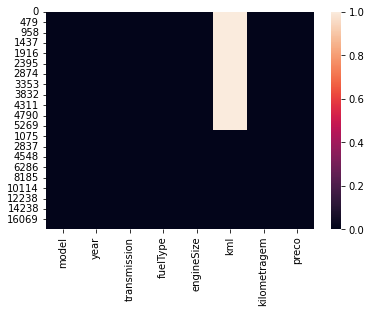

In [187]:
sns.heatmap(df.isnull())

In [189]:
df[df.kml.isna()].model.value_counts() / df.model.value_counts()['Focus']

Focus    0.543119
Name: model, dtype: float64

In [190]:
df.describe()

,year,kml,kilometragem,preco
count,10042.000000,4588.000000,10042.000000,10042.000000
mean,2017.060347,25.546642,37447.575885,73571.484533
std,2.138223,4.563228,33083.223796,25466.408296
min,2002.000000,11.181287,1.609340,2717.550000
25%,2016.000000,23.552978,15097.218540,56522.295000
50%,2017.000000,25.551154,26631.358320,71370.000000
75%,2019.000000,28.612191,49389.437595,92226.510000
max,2020.000000,35.329466,285889.594960,301922.550000


In [191]:
df.fuelType.unique()

array(['Petrol', 'Diesel'], dtype=object)

In [192]:
df[df.kml > 50]

,model,year,transmission,fuelType,engineSize,kml,kilometragem,preco


<AxesSubplot:xlabel='kml'>

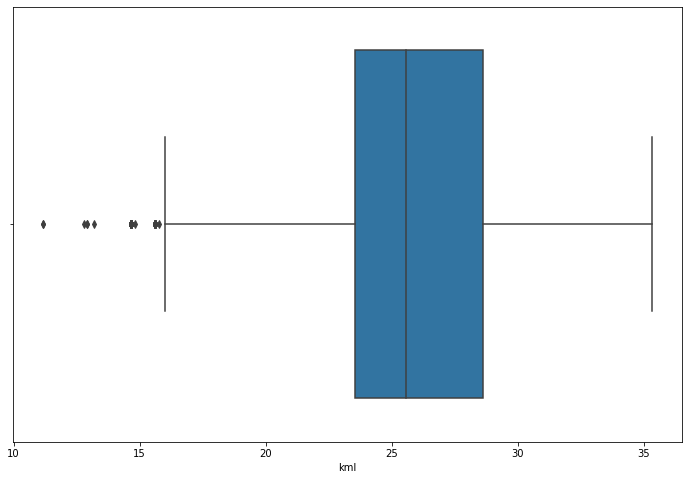

In [193]:
f, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x=df.kml)

## Encoding

In [362]:
df.head()

,model,year,transmission,fuelType,engineSize,kml,kilometragem,preco
0,Focus,2016,Manual,Petrol,1.0,NaN,62526.07768,43920.00
1,Focus,2019,Manual,Petrol,1.0,NaN,19234.83168,73566.00
2,Focus,2019,Manual,Petrol,1.5,NaN,35634.00628,80154.00
3,Focus,2016,Manual,Diesel,1.6,NaN,23414.28766,51880.50
4,Focus,2015,Manual,Diesel,1.6,NaN,11281.47340,54894.51


In [367]:
df = df.drop(df[df.year == 2002].index)

In [368]:
feats_cat = ['year','transmission','fuelType','engineSize']
feats_num = ['kml','kilometragem']

pipe_cat = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
pipe_num = make_pipeline(KNNImputer(),RobustScaler())

col_transf = make_column_transformer((pipe_cat,feats_cat),(pipe_num,feats_num))

In [369]:
col_transf

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['year', 'transmission', 'fuelType',
                                  'engineSize']),
                                ('pipeline-2',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['kml', 'kilometragem'])])

In [370]:
col_transf.fit(df)
df_encoded = col_transf.transform(df)

In [371]:
km = KMeans(n_clusters=8)
km.fit(df_encoded)

KMeans()

In [372]:
df_encoded = pd.DataFrame(df_encoded.todense()).assign(labels = km.labels_)

In [373]:
df_encoded

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044335,1.046841,7
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.726601,-0.215714,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.076355,0.262555,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.576355,-0.093823,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.357143,-0.447667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.290640,-0.262274,2
10037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037126,7
10038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.748768,2.274101,1
10039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.290640,0.154229,2


In [374]:
df_encoded.labels.value_counts()

7    2036
4    1882
6    1512
0    1401
3     988
1     958
2     855
5     409
Name: labels, dtype: int64

In [375]:
df.preco

0         43920.00
1         73566.00
2         80154.00
3         51880.50
4         54894.51
           ...    
17929    101565.00
17933     60390.00
17942     43920.00
17954     87840.00
17963     54894.51
Name: preco, Length: 10041, dtype: float64

In [376]:
focus_similares = df_encoded.assign(preco = df.preco.reset_index(drop=True))

In [377]:
focus_similares[['labels','preco']].groupby('labels').std()

,preco
labels,
0,14493.589000
1,13077.088395
2,28111.509237
3,19263.282806
4,15244.856032
5,12525.242845
6,16510.228089
7,15022.776436


(array([1.002e+03, 3.360e+02, 5.600e+01, 4.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 54625.5  ,  79355.205, 104084.91 , 128814.615, 153544.32 ,
        178274.025, 203003.73 , 227733.435, 252463.14 , 277192.845,
        301922.55 ]),
 <BarContainer object of 10 artists>)

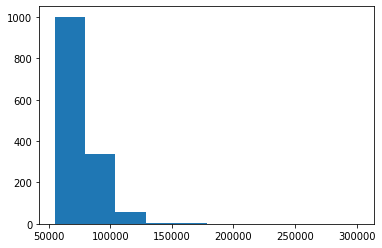

In [378]:
plt.hist(focus_similares[['labels','preco']].query("labels == 0").preco)

## Modelo de Regressão

In [379]:
x = df.drop(['model','preco'],axis=1)
y = df.preco

In [380]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42,test_size=0.2)

In [381]:
col_transf.fit(x_train,y_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['year', 'transmission', 'fuelType',
                                  'engineSize']),
                                ('pipeline-2',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['kml', 'kilometragem'])])

In [382]:
x_train_encoded = col_transf.transform(x_train)
x_test_encoded  = col_transf.transform(x_test)

In [406]:
model = GradientBoostingRegressor(random_state=42,min_samples_leaf=30)

In [407]:
model.fit(x_train_encoded,y_train)

GradientBoostingRegressor(min_samples_leaf=30, random_state=42)

In [408]:
model.score(x_test_encoded,y_test)

0.9154691276408198

In [409]:
focus_similares

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,labels,preco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.044335,1.046841,7,43920.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.726601,-0.215714,4,73566.00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.076355,0.262555,4,80154.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.576355,-0.093823,6,51880.50
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-0.357143,-0.447667,3,54894.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-2.290640,-0.262274,2,101565.00
10037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037126,7,60390.00
10038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.748768,2.274101,1,43920.00
10039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-2.290640,0.154229,2,87840.00


In [419]:
for cluster in focus_similares.labels.unique():
    preco_predito_label_1 = model.predict(focus_similares.query("labels == @cluster").drop(['labels','preco'],axis=1))
    a = focus_similares.query("labels == @cluster").assign(valor_pred = preco_predito_label_1)
    print(a.valor_pred.sum() - a.preco.sum())

1581401.2674682736
-782673.2849265635
564542.2904141843
397499.0377380252
-961782.6360729635
-1020371.0947861746
523933.68072631024
-361809.85899296403


In [ ]:
0.27